In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection for content losses done by Logistic Regression

# Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. 
# The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set 
# and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  
# *Sources*
# Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392


import os, sys
import re
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import pickle
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, make_scorer

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


UTILS_PATH = os.path.join(os.path.abspath(''), '../../', 'utils')
sys.path.append(UTILS_PATH)

import feature_selection as fs
import training as t
import evaluation as e
import evaluation_utils as eu
import figures as f
import settings as s
import pipelines as p
import preprocessing as pp

p.main()  # create/update model settings
seed = s.seed

import contextlib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.figure(figsize=(20, 10))

## settings for cv
kfolds_and_repeats = 10, 5 # 10, 3 # 10, 5  # <k-folds, repeats> for nested cv
inner_cv = RepeatedStratifiedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
outer_cv = RepeatedStratifiedKFold(n_splits=kfolds_and_repeats[0], n_repeats=1, random_state=seed)

# ## make new base results-folder
hcmc_cantho = "hcmc" # "hcmc", "cantho"
# # hcmc_cantho = "hcmc_cantho" # "hcmc", "cantho"
# Path(f"../../{hcmc_cantho}/").mkdir(parents=True, exist_ok=True)
# os.chdir(f"../../{hcmc_cantho}/")
# print(os.getcwd())

## TODO make base outdir ./model_results/chance_of_loss
## save models and their evaluation in following folders:
Path(f"../../model_results/models_trained/chance_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/models_trained/chance_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/models_evaluation/chance_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../../model_results/selected_features/chance_of_loss").mkdir(parents=True, exist_ok=True)




c:\Anaconda\envs\py396_c3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Anna\AppData\Local\Temp\ipykernel_21452\4025252897.py:23: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you 

<Figure size 2000x1000 with 0 Axes>

In [3]:
targets = [("Target_relative_contentloss_euro", "rcloss")]
target, target_plot = targets[0]
pred_target = f"pred_{target}"


## load DS for relative content loss
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_cantho_2013_quicktest.xlsx", header=0)
# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb_cantho.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_cantho.xlsx")  # ACC: ~57%, 260cases from which 140 are zero-loss

## move targets to beginning
# df_candidates.insert(0, "Target_relative_contentloss_euro", df_candidates.pop("Target_relative_contentloss_euro"))

# df_candidates.drop("geometry.1", axis=1, inplace=True)

if target == "Target_relative_contentloss_euro":
    df_candidates[target] = df_candidates[target] * 100  # make target range more comparable with Bred, TODO move to data_clenaing.ipynb


with contextlib.suppress(Exception):
    if target == "Target_relative_contentloss_euro":
        df_candidates.drop("hh_monthly_income_euro", axis=1, inplace=True) 
        df_candidates.drop("shp_registered_capital_euro", axis=1, inplace=True) # drop due to high collinearit with income and sale, and highest number of missing values



In [4]:
## features with most missing values
pp.percentage_of_nan(df_candidates)


01-18-2024 11:51:10 - __preprocessing__ - INFO - Percentage of missing values per feature [%]
 bage                               4.0000
inundation_duration_h              2.0000
b_area                             1.0000
emergency_measures                 0.0000
shp_content_value_euro             0.0000
resilience                         0.0000
precautionary_measures_expensive   0.0000
shp_employees                      0.0000
precautionary_measures_lowcost     0.0000
Target_relative_contentloss_euro   0.0000
geometry                           0.0000
Target_contentloss_euro            0.0000
flood_experience                   0.0000
flowvelocity                       0.0000
contaminations                     0.0000
dtype: float64


In [5]:
# if target == "Target_businessreduction":
#     print("Drop variables for BRed with too many NAN")
#     df_candidates.drop(["shp_content_value_euro"], axis=1, inplace=True)
    
# df_candidates.drop(["shp_registered_capital_euro"], axis=1, inplace=True)

## Explore correlations 
Visualize correlations between candidate predictors and targets incl rloss, abs loss, business reduction

In [6]:
# f.plot_correlations(df_candidates)

In [7]:
# # ### Test : remove / set to np.nan the two datapoints in abs loss which are very high
# sns.regplot(x=df.Target_contentloss_euro, y=df.shp_employees,
#     lowess=True, ci=False,
#     line_kws={'color': 'red', 'lw': 1},
#     scatter_kws={'color': 'black', 's': 20}
#     )

# # #sns.boxenplot(df.Target_contentloss_euro)
# # sns.boxenplot(df.Target_relative_contentloss_euro)
# # # sns.boxenplot(df.Target_businessreduction)
# # sns.boxenplot(df.shp_employees)



**Outlier observe**


In [8]:
# df_candidates_safety = df_candidates

df_candidates[["inundation_duration_h", "b_area", "shp_avgmonthly_sale_euro"]].describe()

,inundation_duration_h,b_area,shp_avgmonthly_sale_euro
count,307.0000,310.0000,312.0000
mean,10.1651,77.0468,357.9429
std,27.1721,51.6844,457.2190
min,0.2000,12.0000,92.1000
25%,2.0000,42.2500,92.1000
50%,3.0000,69.0000,276.2000
75%,6.0000,100.0000,276.2000
max,240.0000,400.0000,2761.9000


In [9]:
# # df_candidates.b_area.describe()
# df_percentiles.describe()

# ## write back to df
# df_candidates["inundation_duration_h"] = df_percentiles["inundation_duration_h"]
# df_candidates["shp_avgmonthly_sale_euro"] = df_percentiles["shp_avgmonthly_sale_euro"]
# df_candidates["hh_monthly_income_euro"] = df_percentiles["hh_monthly_income_euro"]
# df_candidates["b_area"] = df_percentiles["b_area"]

# pp.percentage_of_nan(df_candidates)
df_candidates.inundation_duration_h.describe()

count   307.0000
mean     10.1651
std      27.1721
min       0.2000
25%       2.0000
50%       3.0000
75%       6.0000
max     240.0000
Name: inundation_duration_h, dtype: float64

In [10]:
# # df_candidates = df_candidates.loc[ ~(df_candidates.shp_registered_capital_euro >= 5000), :]
# print( len(df_candidates.loc[df_candidates.shp_registered_capital_euro >= 20000, :]))
# #df_candidates = df_candidates.loc[ ~(df_candidates.shp_registered_capital_euro >= 20000), :]
# print(df_candidates.shape)
# df_candidates.shp_registered_capital_euro.describe()
# # df_candidates.shp_registered_capital_euro.hist(bins=50)

In [11]:
# plot_correlations(df_candidates)

## Fit model

In [12]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return precision_score(y_true, y_pred) # return precision score
    #return accuracy_score(y_true, y_pred)

In [16]:
print(df_candidates.shape)


## Fit model

score_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1_macro": "f1_macro", # only for class balanced
    # "f1": "f1",
}

## test drop flow velocity due to diffenret flooding sources (eg. overwhelmed draingage systems)
# df_candidates = df_candidates.drop("flowvelocity", axis=1)
print(df_candidates.columns)

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 

#pipelines = ["pipe_logreg_bag"]
pipelines = ["pipe_logreg"]
# pipelines = ["pipe_sgd"] # with logreg loss and en penality

eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")
print(hyperparams_set)


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipeline and get model name
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')


    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    

    print( f"\n  ############### Applying {model_name} on {target}:  ###############\n")

    ## load hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging is used, adapt hyperparameeter names
    if "bag" in pipe_name.split("_"):
        print(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    ## load input dataset
    df_Xy = df_candidates
    
    # rm geometry column which only needed for visualization
    df_Xy = df_Xy.drop("geometry", axis=1)

    
    ## drop content value var due taht only needed to realculte losses after BN
    df_Xy.drop(["shp_content_value_euro", "Target_contentloss_euro"], axis=1, inplace=True)
    
    # get predictor names
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

 
    #save to find out which samples are predicted wrongly
    df_candidates_continous = df_candidates.copy()
    df_candidates_continous.dropna(inplace=True)
    
    # ## test impact of median imputation on model performance
    # print("test impact of median imputation on model performance")
    # df_Xy[X_names] = df_Xy[X_names].apply(lambda x: x.fillna(x.median()),axis=0)
    df_Xy.dropna(inplace=True)
    print("Drop records with missing values",
        f"keeping {df_Xy.shape} damage cases for model training and evaluation")
   

    ## set target as binary class
    df_Xy[target][df_Xy[target] > 0] = 1
    df_Xy[target] = df_Xy[target].astype("Int64")

    ## clean df from remaining records containg nan
    df_Xy.dropna(inplace=True) ## TODO test with only nan in target removed

    print("Amount of missing target values should be zero: ", df_Xy[target].isna().sum())
    print(
        "Using ",
        df_Xy.shape[0],
        " records, from those are ",
        (df_Xy[target][df_Xy[target] == 0.0]).count(),
        " cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]
    print(y.describe())


    if model_name != "crf":

        ## save evaluation set for later usage in feature importance
        eval_sets[f"{model_name}"] = df_Xy 
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score="precision",#"f1_macro", #"roc_auc", #"f1_macro", #"accuracy", # best 54%="precision",#", #"f1_macro", #"precision", #"f1_macro", # accuracy
            cv=inner_cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()  # pipe
        
        # from sklearn.utils.class_weight import compute_sample_weight
        # sample_weights_dict = compute_sample_weight(class_weight='balanced', y=df_candidates_continous[target])
        # print(sample_weights_dict)
        # sample_weights = np.where(df_candidates_continous[target].between(0.01, 0.05), 0.5, 0.5) 
        # sample_weights = np.where(df_candidates_continous[target].between(0.01, 0.05), 0.8, 0.2)  ## NOTE curr best number of y_pred with 72 damage cases (0.6/0.4 weigth=15 damage cases in y_pred )
        sample_weights = np.where(df_candidates_continous[target] > 0.01, 0.6, 0.4) # >0.01 , 0.6, 0.4 : 72 damahe cases in ypred from ncv, bad in cantho and final model
        # sample_weights = np.where(df_candidates_continous[target].between(0.0001, 0.15), 0.4, 0.6)  # 0..6 / 0.4 give ca 56 damage cases in ypred NOTE 0.8 / 0.2 44 damage cases in ypred
        # no or only slight sample weight, too high weight such as .8, 0.2 = too less non-damage cases are predicted in NCV
        print(pd.Series(sample_weights).describe())
        print(pd.Series(sample_weights).value_counts())
           
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            #score_metrics={"precision": make_scorer(classification_report_with_accuracy_score)} ,
            score_metrics=score_metrics,
            cv=outer_cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        #model_evaluation_results = me.model_evaluate_ncv(prediction_method="predict_proba")
        model_evaluation_results = me.model_evaluate_ncv(
            #sample_weights=None, 
            sample_weights={'model__sample_weight': sample_weights}, 
            prediction_method="predict_proba"
            )


        ## Classification report for nested cross validation                
        nested_score = cross_val_score(models_trained_ncv, X=X, y=y, cv=outer_cv, 
               scoring=make_scorer(classification_report_with_accuracy_score))
        # Average values in classification report for all folds in a K-fold Cross-validation  
        # print(nested_score) # scores from each fold
        print("classification report from outer cross validation") 
        print(classification_report(originalclass, predictedclass)) 


        ## visual check if hyperparameter ranges are good or need to be adapted
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"

        
        ## Final model

        ## get final model based on best MAE score during outer cv
        # best_idx = list(models_scores[model_name]["test_f1"]).index(max(models_scores[model_name]["test_f1"]))
        # best_idx = list(models_scores[model_name]["test_f1_macro"]).index(max(models_scores[model_name]["test_f1_macro"]))
        best_idx = list(models_scores[model_name]["test_precision"]).index(max(models_scores[model_name]["test_precision"]))
        # best_idx = list(models_scores[model_name]["test_recall"]).index(max(models_scores[model_name]["test_recall"]))
        # best_idx = list(models_scores[model_name]["test_accuracy"]).index(max(models_scores[model_name]["test_accuracy"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        print("used params for best model:", final_model.best_params_)
        final_model = final_model.best_estimator_

        ## get predictions of final model from respective outer test set
        test_set_best = df_Xy.iloc[model_evaluation_results["indices"]["test"][best_idx], :]
        finalmodel_y_pred_proba = final_model.predict_proba(test_set_best.drop(target, axis=1))  # get predictions from final model for its test-set (should be the same as done during model evluation with ncv)
        finalmodel_y_true = test_set_best[target]

        ## store highest predicted probabilities and respective predictions
        finalmodel_y_pred = np.argmax(finalmodel_y_pred_proba, axis=1)  # predicted class (non-damage-case, damage-case)
        finalmodel_y_proba = np.take_along_axis(  # predicted probability that a case is non-damage or damage-case
            finalmodel_y_pred_proba, 
            np.expand_dims(finalmodel_y_pred, axis=1), 
            axis=1
        )
        finalmodel_y_proba = finalmodel_y_proba.flatten()
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../../model_results/models_trained/chance_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)


        ## regression coefficients for linear models
        with contextlib.suppress(Exception):
            models_coef[model_name] = me.calc_regression_coefficients(final_model, finalmodel_y_true, finalmodel_y_pred)
            outfile = f"../../model_results/models_evaluation/chance_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False), f"\n.. saved to {outfile}")
            
            ## check if any regression coefficient is significant 
            if np.min(models_coef[model_name]["probabilities"]) >= 0.05:
                ## manually decorate init_logger, extending with creation of log file for warnings
                logger = s.decorate_init_logger(s.init_logger)("__warning_coefs__") 
                logger.warning("non of the regression coefficients is significant")


    # filename = f'../model_results/models_trained_ncv/{model_name}_{target}.sav'
    # pickle.dump(model, open(filename, 'wb'))
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv

    ## store and save model predictions from all outer test sets
    predicted_values[model_name] = me.residuals  # y_train, y_pred and residual from nested cv
    predicted_values[model_name]["y_true_degree"] = df_candidates_continous[target]

    ## NOTE preserve index from loaded input dataset, use predicted probabilities of loss as input for the estimation of relative content loss
    print(predicted_values[model_name].describe())
    predicted_values[model_name].to_excel(f"../../model_results/selected_features/chance_of_loss/predictions_{target}.xlsx", index=True)

    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")

    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
    #df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]

    print(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds()} seconds\n"
    )


## Print model evaluation based on performance on outer cross-validation 
classifier_model_evaluation = pd.DataFrame(models_scores[model_name]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
classifier_model_evaluation_std = pd.DataFrame(models_scores[model_name]).std(axis=0)   # get respective standard deviations

model_evaluation = pd.concat([classifier_model_evaluation, classifier_model_evaluation_std], axis=1)
model_evaluation.columns = [f"{model_name}_score", f"{model_name}_score_std"]

model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../../model_results/models_evaluation/chance_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
print("Outer evaluation scores:\n", model_evaluation.round(4), f"\n.. saved to {outfile}")

## Print evaluation nested cv
print("y true: \n", predicted_values[model_name]["y_true"].value_counts())
print("y pred from nested cv: \n", pd.Series(predicted_values[model_name]["y_pred"]).value_counts())
# ### Empirical median ~ predicted median
for k,v in predicted_values.items():
    print(f"\n{k} estimators from nested cross-validation:")
    print(eu.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


(312, 17)
Index(['Target_relative_contentloss_euro', 'Target_contentloss_euro',
       'inundation_duration_h', 'water_depth_cm', 'contaminations',
       'flowvelocity', 'flood_experience', 'bage', 'b_area', 'geometry',
       'emergency_measures', 'precautionary_measures_lowcost', 'shp_employees',
       'precautionary_measures_expensive', 'resilience',
       'shp_content_value_euro', 'shp_avgmonthly_sale_euro'],
      dtype='object')
{'LogisticRegression_hyperparameters': {'model__penalty': ['elasticnet'], 'model__tol': [1e-05, 0.001, 0.01, 0.1, 0.5], 'model__C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'model__max_iter': [10, 50, 100, 250, 500], 'model__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], 'model__solver': ['saga'], 'model__random_state': [42]}, 'XGBRegressor_hyperparameters': {'model__n_estimators': [3, 5, 10, 30, 50, 100, 250], 'model__max_depth': [3, 5, 10, 15], 'model__booster': ['gbtree'], 'model__colsample_bytree': [0.33, 0.66, 1.0], 'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.

AttributeError: module 'figures' has no attribute 'plot_confusion_matrix'


% CM: 


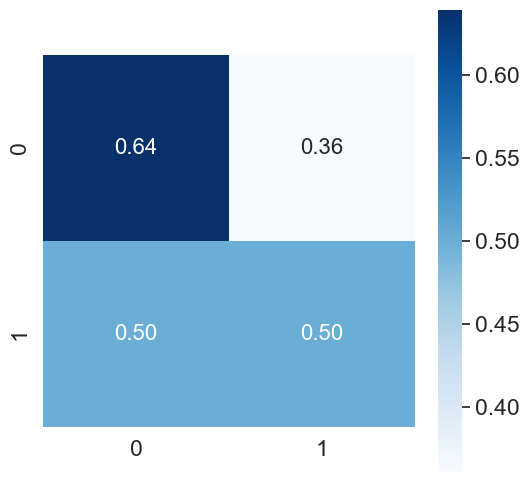

Creating boxplots for range of performane scores from outer folds of nested cross-validation

Classification report from final model:
              precision    recall  f1-score   support

         0.0       0.63      0.94      0.76        18
         1.0       0.67      0.17      0.27        12

    accuracy                           0.63        30
   macro avg       0.65      0.56      0.51        30
weighted avg       0.64      0.63      0.56        30


LogisticRegression from final model:
           nobs  median   mean min max  variance  standard deviation   
empirical    30  0.0000 0.4000  [0, 1]    0.2500              0.4900  \
predicted    30  0.0000 0.1000  [0, 1]    0.0900              0.3000   

           coef variation  
empirical        124.5682  
predicted        305.1286  


<Figure size 640x480 with 0 Axes>

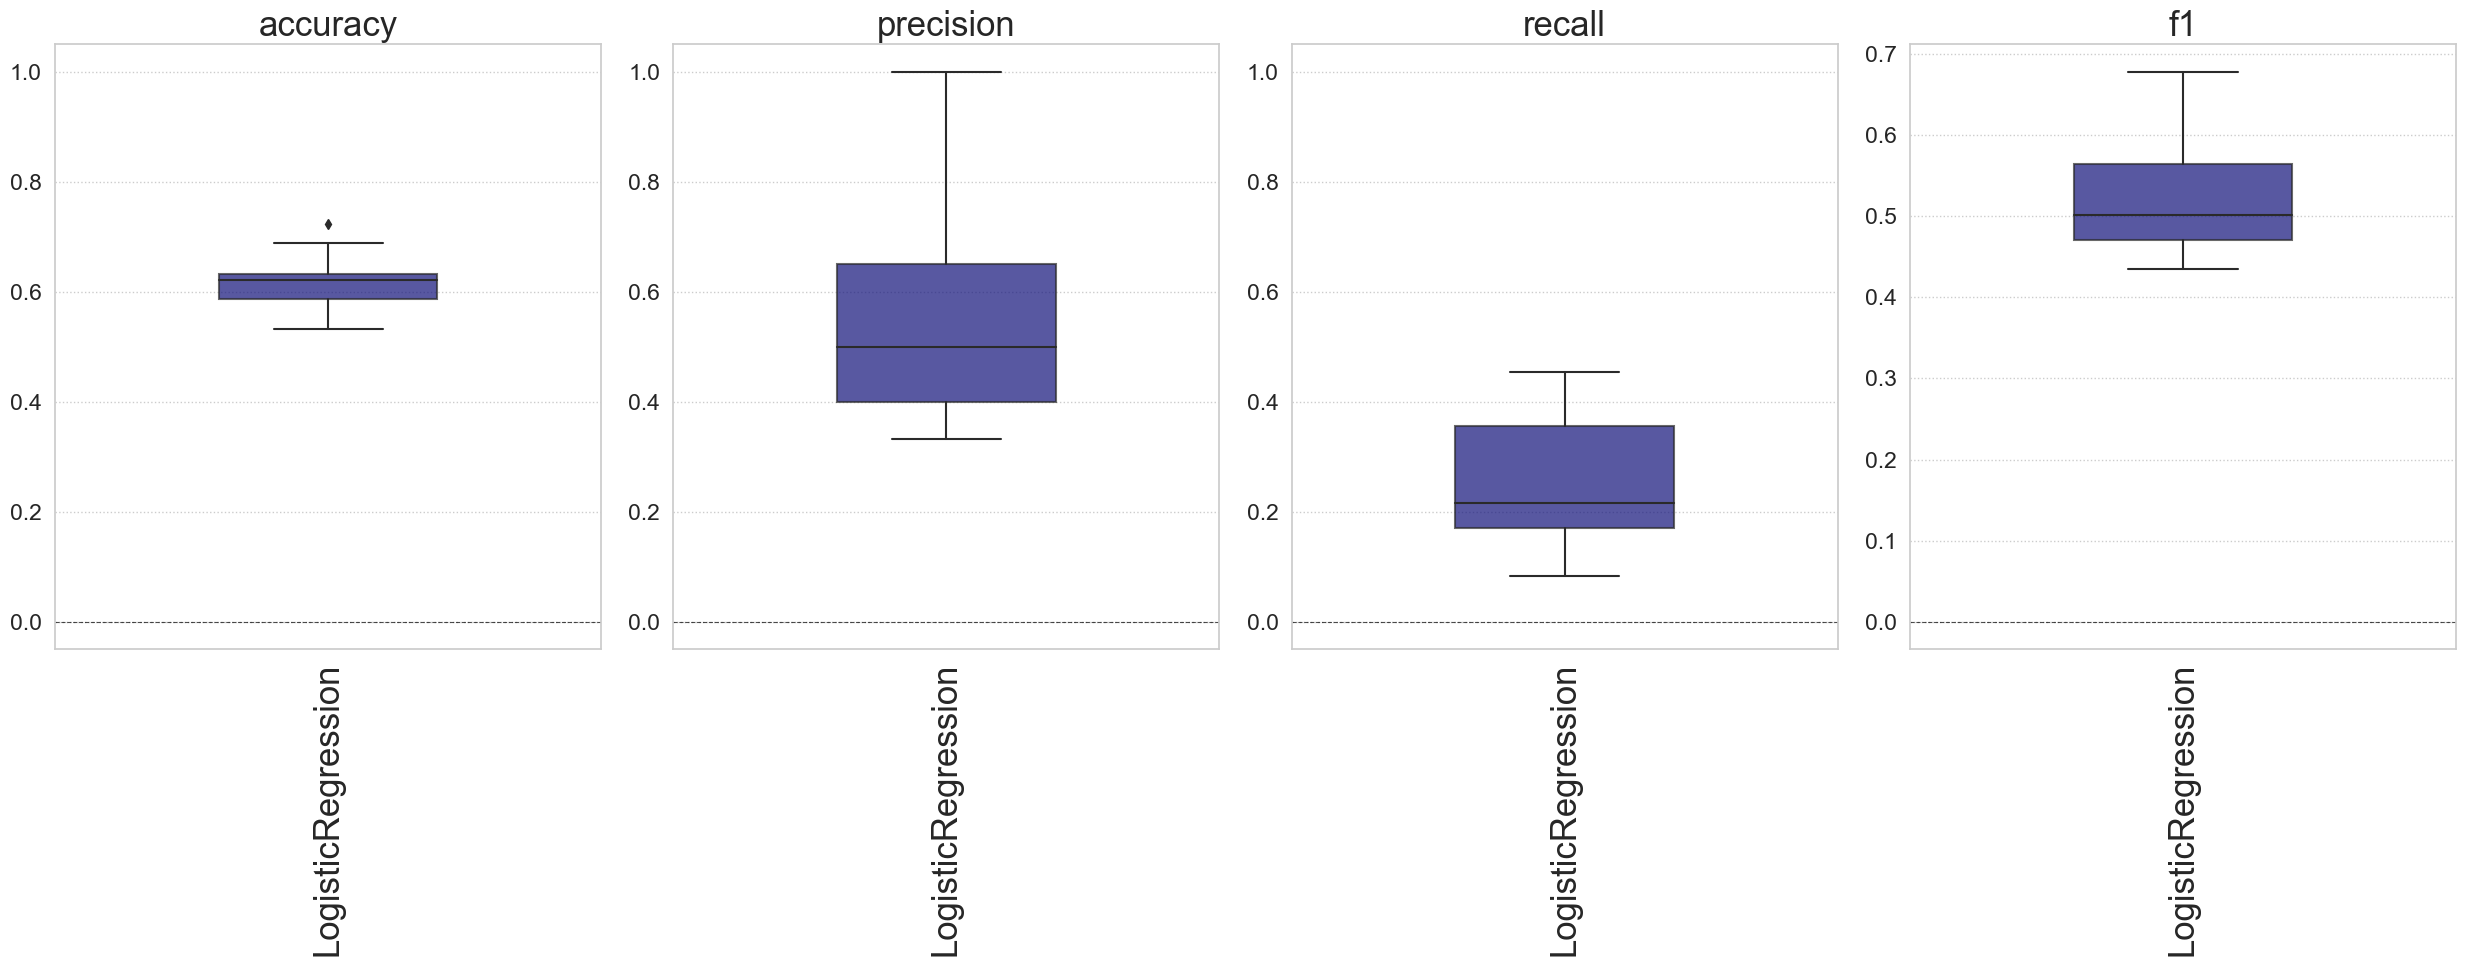

<Figure size 3000x2200 with 0 Axes>

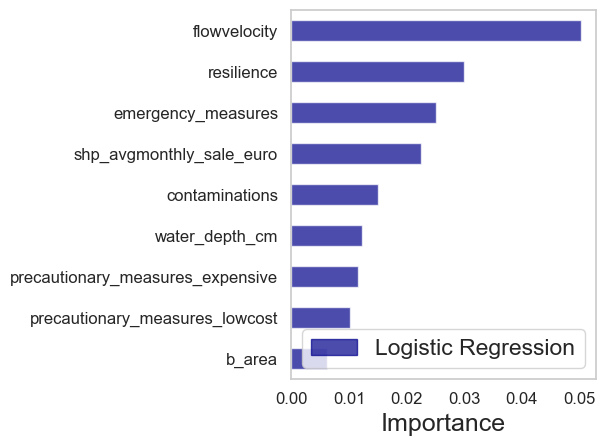

01-18-2024 12:16:30 - __feature_selection__ - INFO - total features: 17
01-18-2024 12:16:30 - __feature_selection__ - INFO - dropped features: 8
01-18-2024 12:16:30 - __feature_selection__ - INFO - selected 9 features: 
['flowvelocity', 'resilience', 'emergency_measures', 'shp_avgmonthly_sale_euro', 'contaminations', 'water_depth_cm', 'precautionary_measures_expensive', 'precautionary_measures_lowcost', 'b_area']

01-18-2024 12:16:30 - __feature_selection__ - INFO - Saving selected features to disk: ../../model_results/selected_features/chance_of_loss/final_predictors_Target_relative_contentloss_euro.xlsx


Dropping 0 records from entire dataset due that these values are nan in target variable
Keeping 312 records and 17 features
Index(['flowvelocity', 'resilience', 'emergency_measures',
       'shp_avgmonthly_sale_euro', 'contaminations', 'water_depth_cm',
       'precautionary_measures_expensive', 'precautionary_measures_lowcost',
       'b_area'],
      dtype='object')


In [17]:
print("\n% CM: ")

f.plot_confusion_matrix(
    predicted_values[model_name]["y_true"],
    predicted_values[model_name]["y_pred"],
    outfile=f"../../model_results/models_evaluation/chance_of_loss/confusionmatrix_{target}.png",
)


## Plot performance ranges of all evaluated estimators from outer cross-validation 
print("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
sns.set_style("whitegrid", {'grid.linestyle': ':'})
f.boxplot_outer_scores_ncv(
    models_scores,
    outfile=f"../../model_results/models_evaluation/chance_of_loss/boxplot_scores4ncv_{target}.png")


## Print evaluation of final model
print("\nClassification report from final model:")
print(classification_report(  finalmodel_y_true, finalmodel_y_pred))

# print("y true: \n", finalmodel_y_true.value_counts())
# print("y pred from final model: \n", pd.Series(finalmodel_y_pred).value_counts())
for k,v in predicted_values.items():
    print(f"\n{k} from final model:")
    print(eu.empirical_vs_predicted(finalmodel_y_true, finalmodel_y_pred))


        
## Feature Importances 
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot[f"{model_name}_importances"] > 0.0, : ] 
df_feature_importances_plot = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=True)


## TODO update with plt_fi() func as soons a its more flexible in number of models passed to func()
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(30, 22), facecolor="w")
fig = df_feature_importances_plot.plot.barh(
    color="darkblue",
    width=0.5,
    alpha=.7,
    )
plt.xlabel("Importance")
plt.ylabel("")
# plt.title(f"Feature Importances for {target.replace('_',' ')}")

top_bar = mpatches.Patch(
    color="darkblue", 
    label=f"{model_name.replace('cR','c R')}", alpha=.7,
)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.show()
 
fig.get_figure().savefig(f"../../model_results/models_evaluation/chance_of_loss/feature_importances_{target}.png", bbox_inches="tight")
plt.close()


### Save final feature space 
## The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_plot[f"{model_name}_importances"].sort_values(ascending=False).index##[:10]
print(final_feature_names)

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../model_results/selected_features/chance_of_loss/final_predictors_{target}.xlsx"
)

## Logreg
# 0       0.61      0.72      0.66       292
# 1       0.49      0.37      0.42       212


Hi Dominik,

i have some questions, 


% CM: 


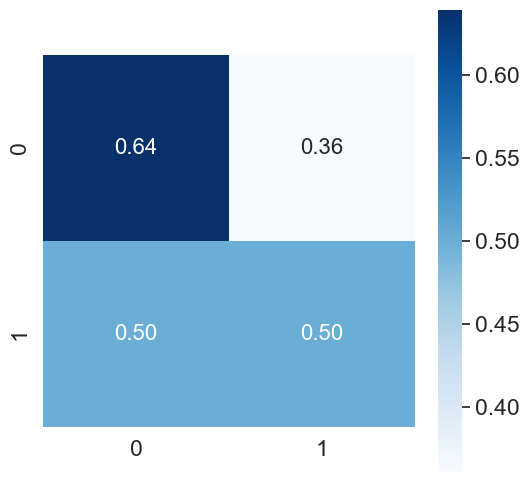

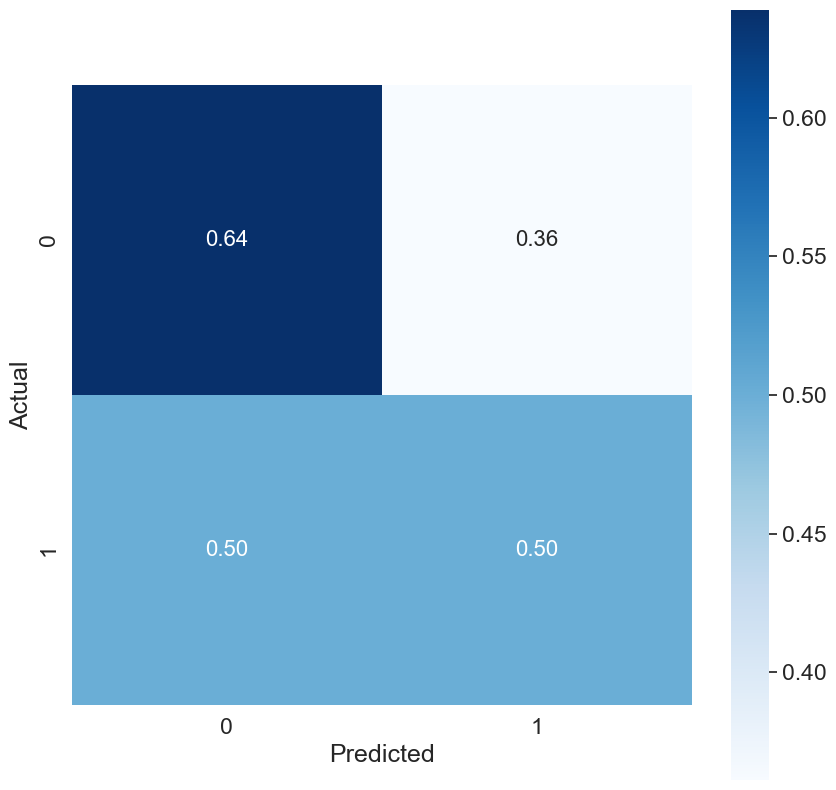

In [14]:
# # Normalise
fig, ax = plt.subplots(figsize=(10,10))

# cm = confusion_matrix(y, y_pred)
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# cmn = pd.DataFrame(cmn)
# cmn.set_index("true_" + cmn.index.astype(str), inplace=True)
# cmn = cmn.add_prefix("pred_")
cm = confusion_matrix(predicted_values[model_name]["y_true"], predicted_values[model_name]["y_pred"], normalize='true')

# plt.figure(figsize=(6,6))
sns.set(font_scale=1.5)
sns.heatmap(
    cm,
    fmt=".2f", cmap="Blues", 
    square=True, 
    annot=True, annot_kws={"size":16},
    cbar=True,
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [15]:
print(classification_report(originalclass, predictedclass)) 

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       180
           1       0.52      0.25      0.33       114

    accuracy                           0.62       294
   macro avg       0.58      0.55      0.53       294
weighted avg       0.59      0.62      0.58       294



### explore final model selection

used params for best model: {'model__tol': 0.01, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 100, 'model__l1_ratio': 0.75, 'model__C': 1}
Classification report from final model:
              precision    recall  f1-score   support

         0.0       0.61      0.98      0.76       180
         1.0       0.50      0.03      0.05       114

    accuracy                           0.61       294
   macro avg       0.56      0.50      0.40       294
weighted avg       0.57      0.61      0.48       294

y true: 
 Target_relative_contentloss_euro
0    180
1    114
Name: count, dtype: Int64
y pred from final model: 
 0.0000    288
1.0000      6
Name: count, dtype: int64

LogisticRegression from final model:
           nobs  median   mean min max  variance
empirical   294  0.0000 0.3878  [0, 1]    0.2400
predicted   294  0.0000 0.0204  [0, 1]    0.0200


5 most important features: ['flowvelocity', 'emergency_measures', 'water_depth_cm', 'contaminations', 'resilience']
CM of final model derived from best precision


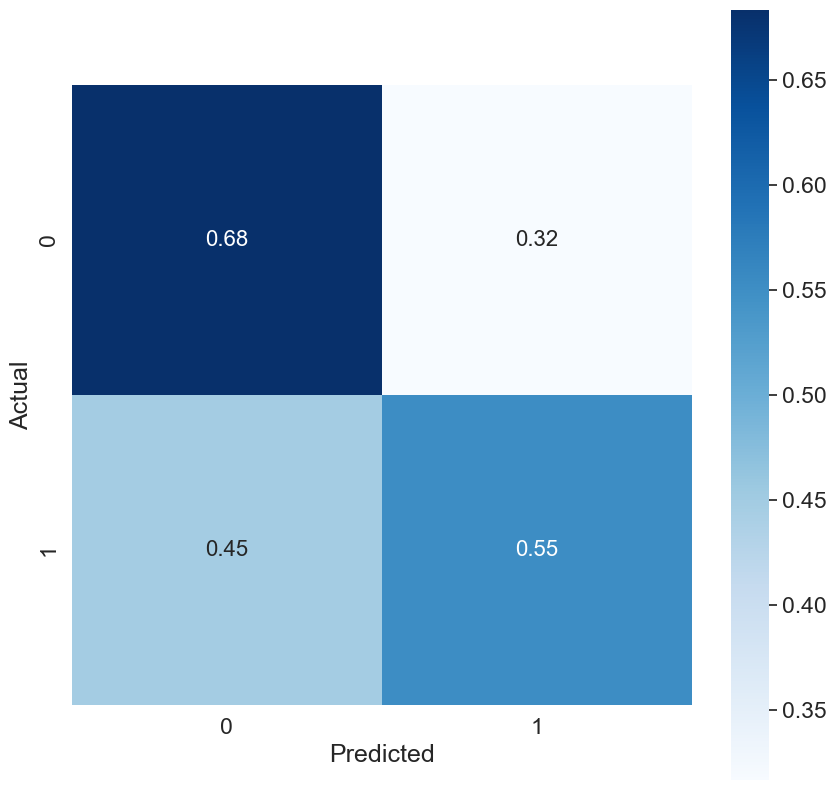

In [16]:
## Final model

## get final model based on best MAE score during outer cv
# best_idx = list(models_scores[model_name]["test_f1_macro"]).index(max(models_scores[model_name]["test_f1_macro"]))
best_idx = list(models_scores[model_name]["test_precision"]).index(max(models_scores[model_name]["test_precision"]))
# best_idx = list(models_scores[model_name]["test_recall"]).index(max(models_scores[model_name]["test_recall"]))
# best_idx = list(models_scores[model_name]["test_accuracy"]).index(max(models_scores[model_name]["test_accuracy"]))
final_model = model_evaluation_results["estimator"][best_idx]
print("used params for best model:", final_model.best_params_)
final_model = final_model.best_estimator_

y_pred = final_model.predict(X)

## Print evaluation of final model
print("Classification report from final model:")
print(classification_report( y, y_pred)) 
print("y true: \n", y.value_counts())
print("y pred from final model: \n", pd.Series(y_pred).value_counts())
for k,v in predicted_values.items():
    print(f"\n{k} from final model:")
    print(eu.empirical_vs_predicted(y, y_pred))


df_feature_importances = pd.DataFrame()
importances = me.permutation_feature_importance(final_model, repeats=5)
importances
df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
df_feature_importances = df_feature_importances.merge(
    df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
    left_index=True, right_index=True, how="outer")
df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
#df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]


print("CM of final model derived from best precision")
# f.plot_confusion_matrix(
#     y,
#     y_pred,
#     outfile=f"../model_results/models_evaluation/chance_of_loss/cm_finalmodel_bestprecision_{target}.png",
# )
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(predicted_values[model_name]["y_true"], predicted_values[model_name]["y_pred"], normalize='true')

sns.set(font_scale=1.5)
sns.heatmap(
    cm,
    fmt=".2f", cmap="Blues", 
    square=True, 
    annot=True, annot_kws={"size":16},
    cbar=True,
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



In [ ]:
## regression coefficients for linear models
with contextlib.suppress(Exception):
    models_coef[model_name] = me.calc_regression_coefficients(final_model, y_pred)
    outfile = f"../../model_results/models_evaluation/chance_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
    # models_coef[model_name].round(3).to_excel(outfile, index=True)
    print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False), f"\n.. saved to {outfile}")
    
    ## check if any regression coefficient is significant 
    if np.min(models_coef[model_name]["probabilities"]) >= 0.05:
        ## manually decorate init_logger, extending with creation of log file for warnings
        logger = s.decorate_init_logger(s.init_logger)("__warning_coefs__") 
        logger.warning("non of the regression coefficients is significant")



coefs_intercept = np.append(model_intercept, list(model_coefs)) [-1.56458721 -0.70734874  0.59627609  1.06888253  0.34580575  0.
 -0.01240081  0.17067599  0.9878536  -1.06942135 -0.05939235  0.56241588
  0.         -0.74564152]
Regression Coefficients:
                             features  coefficients  standard errors  t values   
5                   flood_experience        0.0000           0.1100    0.0000  \
12                     shp_employees        0.0000           0.2240    0.0000   
6                               bage       -0.0124           0.2770   -0.0450   
10  precautionary_measures_expensive       -0.0594           0.1980   -0.3000   
7                             b_area        0.1707           0.3030    0.5630   
4                     contaminations        0.3458           0.1860    1.8560   
1              inundation_duration_h       -0.7073           0.3630   -1.9480   
2                     water_depth_cm        0.5963           0.2690    2.2190   
13          shp_a

In [18]:
## observed small loss predictions 
y_pred_zeroloss = predicted_values[model_name]["y_pred"][predicted_values[model_name]["y_pred"]== 0]
y_true_loss = df_candidates_continous.loc[(df_candidates_continous.Target_relative_contentloss_euro > 0.0), :]

## False positives
fp = y_true_loss[y_true_loss.index.isin(y_pred_zeroloss.index)]
print(fp.shape)

## compare predction for very small losses < 1% with y_true_loss
print(fp.sort_values("Target_relative_contentloss_euro", ascending=True).head(20))
print(fp.loc[fp.Target_relative_contentloss_euro < 1.0,:])

(87, 14)
     Target_relative_contentloss_euro  inundation_duration_h  water_depth_cm   
47                             0.1016                 5.0000              20  \
19                             0.1794                 9.0000              20   
68                             0.2401                 5.0000              55   
10                             0.3997                 0.5000              10   
40                             0.4997                 1.0000               5   
236                            0.5409                 2.0000              20   
94                             0.7169                 2.0000              10   
225                            0.7495                 4.0000               5   
11                             0.7994                 7.0000              50   
9                              0.8059                 2.0000               3   
28                             0.8125                 2.0000               2   
110                            

-> all small losses (<1%>) were predicted as zero damages (1/5 of all FPs)

In [28]:
len(y_true_loss.Target_relative_contentloss_euro)


114

In [25]:
# true sm losses
print(y_true_loss.loc[y_true_loss.Target_relative_contentloss_euro < 5.0, :].index)

# sm losses wrongly predicted as no-losss
print(fp.loc[fp.Target_relative_contentloss_euro < 5.0,:].index)

Index([  7,   9,  10,  11,  19,  23,  26,  28,  29,  39,  40,  47,  49,  62,
        68,  74,  80,  91,  94, 104, 106, 110, 115, 117, 122, 127, 130, 131,
       142, 150, 151, 152, 160, 164, 165, 166, 168, 169, 170, 172, 186, 193,
       197, 200, 203, 210, 215, 218, 220, 221, 225, 230, 231, 233, 236, 241,
       242, 243, 246, 267, 274, 281, 289, 291, 298, 299],
      dtype='int64')
Index([  7,   9,  10,  11,  19,  23,  28,  29,  39,  40,  47,  49,  68,  74,
        80,  91,  94, 104, 106, 110, 117, 127, 130, 131, 142, 150, 151, 152,
       160, 164, 165, 166, 168, 170, 172, 186, 193, 197, 200, 203, 210, 215,
       218, 221, 225, 230, 231, 233, 236, 242, 267, 291, 298, 299],
      dtype='int64')


In [29]:
# true high losses
print(y_true_loss.loc[y_true_loss.Target_relative_contentloss_euro >= 5.0, :].index)

# high losses wrongly predicted as no-losss
print(fp.loc[fp.Target_relative_contentloss_euro >= 5.0,:].index)

Index([ 15,  17,  24,  32,  36,  53,  59,  65,  75,  82,  87,  90, 103, 107,
       114, 119, 121, 129, 132, 140, 148, 149, 155, 156, 157, 188, 213, 216,
       219, 223, 224, 235, 253, 257, 260, 265, 266, 269, 270, 271, 273, 277,
       287, 290, 292, 294, 295, 304],
      dtype='int64')
Index([ 17,  24,  36,  53,  59,  65,  82,  90, 103, 107, 114, 119, 121, 129,
       140, 149, 156, 157, 188, 216, 219, 223, 224, 265, 269, 270, 271, 277,
       287, 290, 292, 294, 304],
      dtype='int64')


<Axes: >

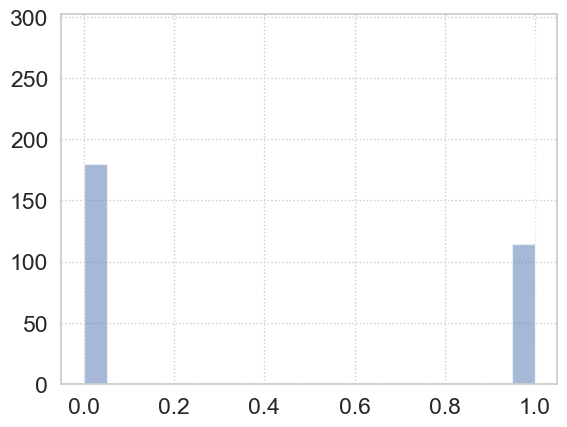

In [50]:
pd.Series(y).hist(bins=20, alpha=.5)
pd.Series(y_proba).hist(bins=20, alpha=.5)

In [51]:
# # # # # # # # # # #  HCMC   # # # # # # # # # # 
#  no balancing in class or weights, no clip of < 1% damages
# Outer evaluation scores:precision

#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                     0.5847                        0.0628
# precision                    0.5161                        0.1738
# recall                       0.3473                        0.1292
# f1_macro                     0.5373                        0.0697 

#  no balancing in class or weights, with clip of < 1% damages
# Outer evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                     0.6321                        0.0890
# precision                    0.6484                        0.1288
# recall                       0.5317                        0.1477
# f1_macro                     0.6205                        0.0910
 
# with sample weights > 0.01, 0.6, 0.4 , no class balancing
# similar to above


## ****** --> prefer this one: due that small losses are not clipped *****
#  no balancing in class or weights, no clip of < 1% damages, with 99. percentile clip
# Outer evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                     0.6438                        0.1157
# precision                    0.6626                        0.1557
# recall                       0.5099                        0.1376
# f1_macro                     0.6301                        0.1142


#  no balancing in class or weights, with clip of < 1% damages,  with 99. percentile clip
# uter evaluation scores:
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                     0.6214                        0.0752
# precision                    0.6149                        0.1356
# recall                       0.4256                        0.1177
# f1_macro                     0.5895                        0.0705 



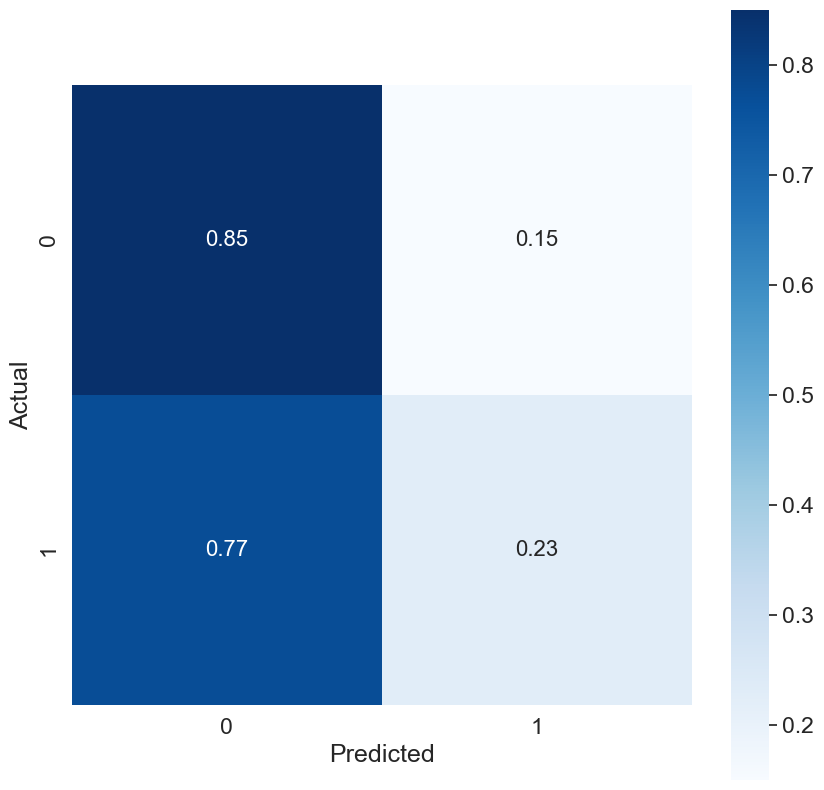

In [20]:
from sklearn.metrics import confusion_matrix

# Normalise
fig, ax = plt.subplots(figsize=(10,10))

# cm = confusion_matrix(y, y_pred)
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# cmn = pd.DataFrame(cmn)
# cmn.set_index("true_" + cmn.index.astype(str), inplace=True)
# cmn = cmn.add_prefix("pred_")
cm = confusion_matrix(predicted_values[model_name]["y_true"], predicted_values[model_name]["y_pred"], normalize='true')

# plt.figure(figsize=(6,6))
sns.set(font_scale=1.5)
sns.heatmap(
    cm,
    fmt=".2f", cmap="Blues", 
    square=True, 
    annot=True, annot_kws={"size":16},
    cbar=True,
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,shp_employees,shp_avgmonthly_sale_euro
47,0.1016,5.0000,20,0.4000,1,16,19.0000,120.0000,0.3333,0.7500,0.0000,2.3333,2,92.1000
19,0.1794,9.0000,20,0.4000,1,76,45.0000,55.0000,0.3333,0.5000,0.3333,1.0000,3,276.2000
68,0.2401,5.0000,55,0.5000,1,36,28.0000,56.0000,0.5000,1.0000,0.3333,1.3333,3,92.1000
10,0.3997,0.5000,10,0.2000,1,3,45.0000,35.0000,0.1667,0.0000,0.3333,3.6667,1,92.1000
40,0.4997,1.0000,5,0.1000,1,76,30.0000,90.0000,0.5000,0.7500,0.3333,2.6667,1,92.1000
236,0.5409,2.0000,20,0.4000,1,36,19.0000,80.0000,0.6667,0.5000,0.6667,2.3333,4,736.5000
94,0.7169,2.0000,10,0.3000,1,151,19.0000,40.0000,0.3333,0.7500,0.0000,3.6667,2,92.1000
225,0.7495,4.0000,5,0.4000,1,76,26.0000,90.0000,0.5000,0.7500,0.0000,2.6667,1,92.1000
11,0.7994,7.0000,50,0.2000,1,36,20.0000,400.0000,0.5000,0.2500,0.3333,3.0000,3,276.2000
9,0.8059,2.0000,3,0.4000,0,36,22.0000,45.0000,0.1667,0.2500,0.3333,3.3333,2,92.1000


In [110]:
df_candidates_continous.loc[
    (df_candidates_continous.Target_relative_contentloss_euro > 0.0) &
    (df_candidates_continous.Target_relative_contentloss_euro < 1.0),:]

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,flowvelocity,contaminations,flood_experience,bage,b_area,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,shp_employees,shp_avgmonthly_sale_euro
7,0.9208,12.0000,20,0.2000,1,36,21.0000,54.0000,0.3333,0.2500,0.3333,2.0000,2,1473.0000
9,0.8059,2.0000,3,0.4000,0,36,22.0000,45.0000,0.1667,0.2500,0.3333,3.3333,2,92.1000
10,0.3997,0.5000,10,0.2000,1,3,45.0000,35.0000,0.1667,0.0000,0.3333,3.6667,1,92.1000
11,0.7994,7.0000,50,0.2000,1,36,20.0000,400.0000,0.5000,0.2500,0.3333,3.0000,3,276.2000
19,0.1794,9.0000,20,0.4000,1,76,45.0000,55.0000,0.3333,0.5000,0.3333,1.0000,3,276.2000
28,0.8125,2.0000,2,0.2000,1,16,21.0000,130.0000,0.3333,0.2500,0.0000,3.3333,1,92.1000
39,0.9993,0.5000,10,0.4000,1,76,18.0000,53.0000,0.5000,0.2500,0.3333,1.3333,1,276.2000
40,0.4997,1.0000,5,0.1000,1,76,30.0000,90.0000,0.5000,0.7500,0.3333,2.6667,1,92.1000
47,0.1016,5.0000,20,0.4000,1,16,19.0000,120.0000,0.3333,0.7500,0.0000,2.3333,2,92.1000
62,0.3997,3.0000,40,0.5000,1,76,21.0000,98.0000,0.5000,0.2500,0.0000,4.3333,1,92.1000


In [ ]:
y_pred


LogisticRegression
           nobs  median   mean min max  variance
empirical   294  0.0000 0.3878  [0, 1]    0.2400
predicted   294  0.0000 0.1837  [0, 1]    0.1500


,pred_0,pred_1
true_0,153,27
true_1,87,27


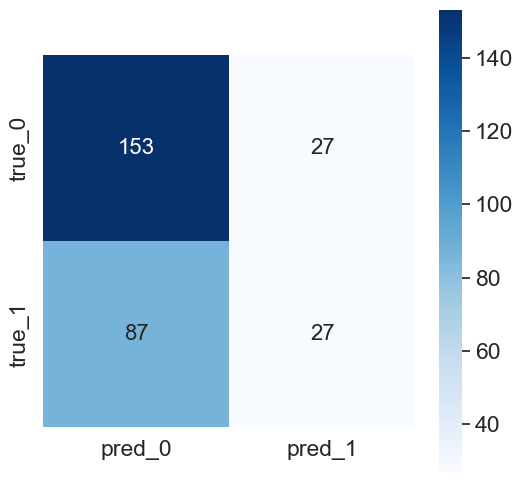

In [57]:


### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.

# ## store partial dependences for each model
# pdp_features = {a : {} for a in [model_name]}

# for model_name in [model_name]:

#     Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
#     X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
#     X_pdp = pd.DataFrame(
#         MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
#         columns=X.columns
#         )
#     Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

#     for predictor_name in X.columns.to_list(): 
#         features_info =  {
#             #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
#             "model" : final_models_trained[model_name], 
        #     "Xy" : Xy_pdp, 
        #     "y_name" : target, 
        #     "feature_name" : predictor_name, 
        #     "scale"  : True
        # }         
        # # get Partial dependences for sklearn models
        # partial_dep = me.get_partial_dependence(**features_info)

        # pdp_features[model_name][predictor_name] = partial_dep


# ## Plot PDP

# most_important_features = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=False).index

# categorical = [] # ["flowvelocity", "further_variables .."]
# ncols = 1
# nrows = len(most_important_features[:10])
# idx = 0

# plt.figure(figsize=(5,25))
# # plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


# ## create PDP for all three models
# for feature in most_important_features[:10]:
#     for model_name, color, idx_col in zip([model_name], ["darkblue"], [0]):
        
#         # idx position of subplot
#         ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
    #     feature_info = {"color" : color, "ax" : ax} 

    #     # plot
    #     df_pd_feature = pdp_features[model_name][feature]  
    #     p = f.plot_partial_dependence(
    #         df_pd_feature, 
    #         feature_name=feature, 
    #         partial_dependence_name="yhat", 
    #         categorical=[],
    #         outfile=f"../model_results/models_evaluation/can_tho/chance_of_loss/pdp_{target}.png",
    #         **feature_info
    #         )
    #     p

    # idx = idx + 1

# #plt.subplots_adjust(top=0.2)
# plt.savefig(f"../model_results/models_evaluation/can_tho/chance_of_loss/pdp_{target}.png", bbox_inches="tight")


# ### Empirical median ~ predicted median
# Compare median and mean of predicted  vs observed target values
for k,v in predicted_values.items():
    print(f"\n{k}")
    print(eu.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# HCMC LogReg : with removed 4 highest abs loss removed ACC 0.61
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                       0.61                          0.08
# precision                      0.53                          0.10
# recall                         0.57                          0.15
# f1_macro                       0.59                          0.08 

f.plot_confusion_matrix(
    predicted_values[model_name]["y_true"],
    predicted_values[model_name]["y_pred"],
    outfile=f"../model_results/models_evaluation/chance_of_loss/pdp_{target}.png",
)



In [525]:
## no class balancing
##          1.0       0.42      0.88      0.57       107   # no sample weights
##          1.0       0.42      0.96      0.59       107   # with sample weight 0.7 / 0.3
##          1.0       0.42      0.96      0.59       107   # with sample weight 0.3 / 0.7


## only class balancing (no sample weights)
#"model__class_weight": 0:0.3 , 1:0.7,
#         1.0       0.42      0.96      0.59       107


# #sampel 6 ? 4 with balanced class weighs and less kfolds/repas 
# accuracy                      0.562                         0.079
## --> less good as with stronger sample wieghts , also less good in detailed c.report 
 
# ## sample 8 / 2 (with balanced) + less kfolds/repas 
# accuracy                      0.562                         0.079 no resart # with restart

###################################

# ## sample 8 / 2 (no balancing =None) + less kfolds/repas 
# accuracy                      0.573                         0.066

# ## sample 8 / 2 (no balancing =None) + many kfolds/repas 
## ACC 60%

#          0.0       0.82      0.21      0.33       153
#          1.0       0.45      0.93      0.61       107

#     accuracy                           0.51       260
#    macro avg       0.64      0.57      0.47       260
# weighted avg       0.67      0.51      0.45       260

### Save TP, FN, FP and TN to disk to create QGIS map

In [ ]:
# raw_data["geometry"].str.findall(r'(\d+\.\d+)')

df_candidates_geom = df_candidates[final_feature_names.insert(-1, "geometry")]

df_candidates_geom["geometry"] = df_candidates_geom["geometry"].str.findall(r'(\d+\.\d+)').astype(str)
geom_col = df_candidates_geom["geometry"].str.split(' ', n=1, expand=True)
geom_col

df_candidates_geom = gpd.GeoDataFrame(df_candidates_geom,  
           geometry=gpd.points_from_xy(
               geom_col[0].str.extract(r'(\d+\.\d+)')[0],
               geom_col[1].str.extract(r'(\d+\.\d+)')[0],
    ))
df_candidates_geom = df_candidates_geom.set_crs(4326) 
df_candidates_geom.tail(2)

# glimpse =  dff[~ dff.is_empty] 
# #glimpse = glimpse[glimpse.flowvelocity]
# glimpse.geometry.explore() 



## visual check of SMEs locations
import folium

glimpse = df_candidates_geom[ ~df_candidates_geom.is_empty]   # drop emtpy geoms
glimpse_geolocations = df_candidates_geom[ ~df_candidates_geom.is_empty]   # drop emtpy geoms
glimpse_geolocations = glimpse_geolocations[["geometry", "flowvelocity_r", "flowvelocity_s"]]
m = glimpse.geometry.explore(name="survey ds", color="red", k=10)  
m = glimpse_geolocations.explode(ignore_index=True).explore(
    m=m, 
    name="flowvelocity per event type",
    column="flowvelocity", 
    popup=True, 
    #tooltip="Nr_Floors", 
    cmap="viridis"
)    # BT_Moon BT_TUEB_2

folium.LayerControl().add_to(m)
m



NameError: name 'df_candidates' is not defined

In [ ]:
# f.plot_correlations(df_candidates)
#         "model__class_weight": [{0:"0.33", 1:"0.67"}],

from sklearn.metrics import classification_report
print(classification_report( y, y_pred)) # baggin: ACC: 0.58
              

In [ ]:
# models_coef#[f"LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
# model_coef[f"LogisticRegression_selfbuilt"]

In [ ]:
# models_cv_result.keys()

In [ ]:
## scoring=ACC 5*5 ACC:
# outer CV: ACC: 0.573 (0.087)
# outer CV: precision: 0.491 (0.105)
# outer CV: recall: 0.607 (0.176)
# outer CV: F1: 0.529 (0.114)

## scoring=ACC 10*5 ACC: 

In [ ]:
# ValueError: Classification metrics can't handle a mix of binary and continuous targets
predicted_probabilities
#pd.Series(y_pred).describe()


In [ ]:
#logistic_reg_cv
# ?logistic_reg
# ?KFold
predicted_probabilities

## use continous  probability values for weights in BN
# --> gives chance that a certain vlaue of loss occures 
## model bias over/underestimation of losses


In [ ]:
model_coef["LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["LogisticRegression_selfbuilt"].sort_values("features")

In [ ]:
model_coef["logreg_freg"].sort_values("features")

## Evaluation

#### Coefficients of Logistic Regression 

LogReg:  The algorithm estimates the probability of an event occurring by fitting a logistic function to a set of input variables. The coefficients for logistic regression are used to measure the strength of the relationship between the input variables and the output variable.
LogReg doesnt reduce the influence of correlated variables on the model (in contrast to the regularization term in Linear models.)

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
model_coef["logreg_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["logreg_selfbuilt"].sort_values("features")


In [ ]:
#df_candidates.resistant_material_building_impl.value_counts()

In [ ]:
model_coef["logreg_selfbuilt"].sort_values("features")

In [ ]:
# #models_trained["LogisticRegression"]
# #print(model_coef.keys())
# #model_coef

# import statsmodels.api as sm

# df_candidates_sm = pd.get_dummies(df_candidates_t, columns=[target], drop_first=True)
# y_sm = df_candidates_sm[[target+"_1"]]
# X_sm = df_candidates_sm.drop(target+"_1", axis=1)
# sm_model = sm.Logit(y_sm, sm.add_constant(X_sm)).fit(disp=0)
# print(sm_model.pvalues)
# sm_model.summary()




In [ ]:
# #import statsmodels.api as sm

# print(model_coef.keys())
# print(model_coef["LogisticRegression"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]

### Confusion matrix

In [ ]:
## based on neste cv
f.plot_confusion_matrix(
    predicted_values["y_pred"],
    predicted_values["y_pred"],
    show_absolute=True,
    show_normed=True,
    colorbar=False,
    model_name="Logistic_Regression", target_name=target)

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean / variance / std  compared to empirical distribution

In [ ]:
# print("Logistic Reg (binary classification): ", target)
# e.empirical_vs_predicted(
#     X, y.astype(int),
#     models_list=[final_models_trained["LogisticRegression"].named_steps["model"]]    
#     #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
# )

# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


In [ ]:
# #scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# #pd.DataFrame(scores).set_index("test_score").sort_index().T

# # #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
# #pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
# pd.DataFrame(model.cv_results_)[
#         [                                   # only important cv evaluation metrics 
#             "mean_test_score",
#             "mean_fit_time",
#             "rank_test_score",
#             "param_name__estimator__C",
#             "param_name__estimator__penalty",
#             "param_name__estimator__l1_ratio",
#             "param_name__estimator__max_iter"
#         ]
#     ].set_index("rank_test_score").sort_index().T


In [ ]:
## reload models

print(targets)
target = targets[0]

logistic_reg_eval = pickle.load(open(f"../model_results/models_trained/logisticreg_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


### Feature importance

In [ ]:
## TODO test to get std of FI _ C:\Users\Anna\Documents\UNI\MA_topic\recycling\sm2t-traffic-speed-model-partial-dependence\SM2T\sm2t-traffic-speed-model_partialDep\traffic_speed_model\modelling.py
#    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # based on RF_fi_ 

#plt.rcParams['axes.grid'] = 'none'
#s = df_feature_importances

In [ ]:
### drop features which dont reduce the loss
#df_feature_importances = s
df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances >= 0.0001, : ] 
df_feature_importances = df_feature_importances.sort_values("logreg_importances", ascending=True)

plt.figure(figsize=(30, 22), facecolor="w")
df_feature_importances.plot.barh(
    color="darkblue",
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="logistic regression")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
#plt.axes().set_facecolor("w")
plt.grid(False)
#plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'../model_results/models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



###  Partial dependences

In [ ]:
## store partial dependences for each classification algorithm

pdp_features = {a : {} for a in ["LogisticRegression"]}

me = e.ModelEvaluation()


for model_name in ["LogisticRegression"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         

        if model_name != "crf":   
            print(predictor_name)
            partial_dep = me.get_partial_dependence(
                **features_info
            )
        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = me.decorator_func(       #  change function only temporally        
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True
                **features_info
            ) (me.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../model_results/models_evaluation/chance_of_loss/pdp_{target}.png",
            **feature_info
            )
        p

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.png", bbox_inches="tight")
